In [38]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy import constants
from ipywidgets import interact
import matplotlib.gridspec as gridspec
import time

In [43]:
# To save some typing
pi = np.pi
hbar = constants.hbar
# Better defauls
plt.rcParams['figure.dpi'] = 100

Plotting routines (collapsed cell):

In [1]:
# Let's make a function to make these plots on demand

def plot_cavity():
    plt.figure(figsize=(12,3.5))
    G = gridspec.GridSpec(1, 3)
    plt.subplot(G[0,:-1])
    plt.plot(t*1e6,np.real(da), label="Real")
    plt.plot(t*1e6,np.imag(da), label="Imag")
    plt.plot(t*1e6,np.abs(da), label="")
    plt.axhline(0,ls=":", c="grey")
    plt.legend()
    plt.ylabel("Cavity field amplitude $da$");
    plt.xlabel("Time ($\mu$s)")
    plt.subplot(G[0,2])
    m = np.max(np.abs(da))*1.2
    plt.plot(np.real(da), np.imag(da))
    plt.xlim((-m,m))
    plt.ylim((-m,m))
    plt.axhline(0,ls=":", c="grey")
    plt.axvline(0,ls=":", c="grey")
    plt.tight_layout()


def plot_both():
    plot_cavity()
    plt.figure(figsize=(12,4)) 
    G = gridspec.GridSpec(1, 3)
    plt.subplot(G[0,:-1])    
    plt.plot(t*1e6,np.real(dx), label="dx")
    plt.axhline(0,ls=":", c="grey")
    plt.legend()
    plt.ylabel("Mechanical displacement $x$");
    plt.xlabel("Time ($\mu$s)");

# Linearized equations

We now consider linearized optomechanics. (We follow here the notation and derivation in the thesis of Frank Buters.) We drive the cavity with a constant coherent state and then consider the small displacements of the cavity field on top of the steady-state solution of the cavity response of this drive:

<img width=200 src='da.png'></img>
<img width=200 src='abar.png'></img>

and 

<img width=200 src='dx.png'></img>
<img width=150 src='xbar.png'></img>

The resulting equations are: 

<img width=600 src="linearized_mechanics.png"></img>

<img width=350 src="linearized_cavity.png"></img>


Note that since this is perturbation on the steady state, it is not possible to simulate the dynamics of the ring-up of the cavity from the strong drive, for example, since these describe the deviations of the cavity from the steady state drive amplitude of the cavity.

Note also that we no longer apply a coherent external drive for the pump, it is already implicit in the equations of motion and is captured in $\bar a$. 

Also, in these equations, we are always in the rotating frame of the pump signal. The detuning $\Delta$ is now fixed and determined by the detuning of the frequency of the strong pump from the cavity resonance: $\Delta = \omega_{\rm pump} - \omega_0$. 

The frequency of the probe signal in the simulation should then be chosen based on detuning from the pump signal (ie. it's frequency in the rotating frame of the pump). 

For linear OM, it is more convenient to parametrize this in terms of $g = g_0 \bar a$. In terms of the above parameters: 

$$
G = \frac{g_0}{x_{zpf}} = \frac{g}{\bar a x_{zpf}}, \ \ \ \ \ G\bar a = \frac{g}{x_{zpf}} 
$$

In this parametrization, we have:

$$
\frac{dv}{dt} = -\gamma v - \omega_m^2 x + \frac{\hbar g}{m x_{zpf}}(da+da^*)
$$

$$
\frac{d(da)}{dt} = \left[i\Delta - \frac{\kappa}{2}\right]da + i\frac{g}{x_{zpf}}dx 
$$

## The linearized integrator

In [20]:
def dydt(t, y):
    v = y[0]
    dx = y[1]
    da = y[2]
    
    dy0 = -gamma*v - (w_m**2)*dx + hbar*g/m/x_zpf*np.real(da)
    dy1 = v
    dy2 = 1j*(delta)*da - kappa/2.0*da + 1j*g/x_zpf*dx + \
            np.sqrt(kext)*np.sqrt(probe)*np.exp(1j*w_probe*t)
    
    return np.array([dy0, dy1, dy2])

Parameters:

* `delta`: Detuning of the pump from the cavity resonance
* `probe`, `w_probe`: Probe power and probe angular frequency, relative to rotating frame frequency
* `w_m`, `gamma`: Mechanical angular frequency, mechanical damping rate
* `m`: Mass of mechanical resonator
* `g`: Multiphoton coupling rate
* `x_zpf`: Zero point fluctuation amplitude = `sqrt(hbar/2/m/w_m)`

Variables:

* `da`: (Complex-valued) linear Cavity field variable
* `dx`, `v`: mechanical displacement (relative to steady state) and velocity

# Testing and benchmarking

## Basic test

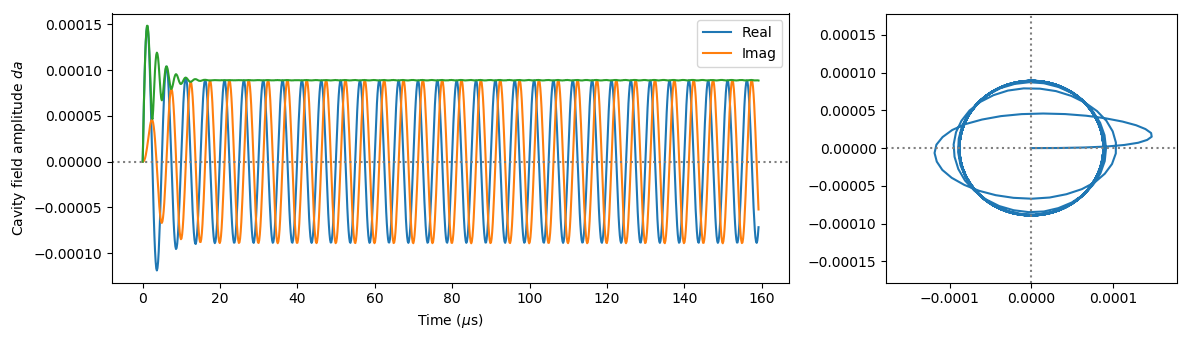

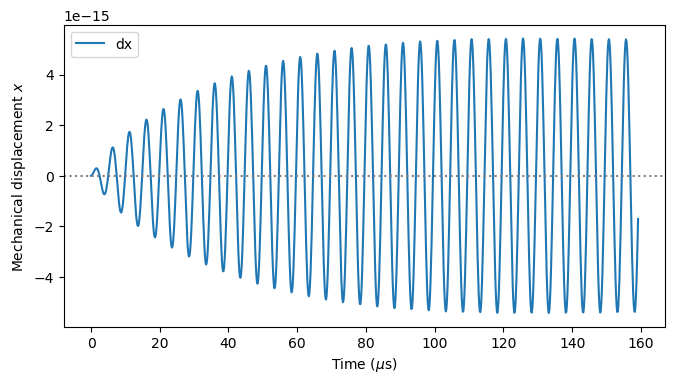

In [23]:
## Mechanics

gamma = 10e3 *2*pi # Hz * 2pi
m = 200e-12 *2*pi # kg
w_m = 200e3 *2*pi # Hz * 2pi

# Derived quantitites
x_zpf = np.sqrt(hbar/2/m/w_m)

## Cavity

delta = -w_m

kappa = 100e3 * 2*pi # Hz * 2pi
kext = 50e3 # Hz * 2pi
delta = -w_m # Hz * 2pi

probe = 1 # Power? 
w_probe = w_m # Relative to what? 

## Coupling

g = 1e3 *2*pi # kHz

# Initial conditions

x0 = 0
v0 = 0
a0 = 0+0j # Need this to be complex to force a complex-valued integrator
y0 = [x0, v0, a0]

# How long should we run simulation?
# Dynamnics for mechanics will be on the order of 1/gamma

T = 10/gamma
t = np.linspace(0,T,1000)

sol = solve_ivp(dydt, [0,T], y0, t_eval=t, method='BDF')
dx = sol.y[0]
v = sol.y[1]
da = sol.y[2]

plot_both()

This seems to make sense: adding the probe field, it will beat with the pump tone and produce an oscillating force on  the mechanical resonator, ringing it up to a coherent amplitude. 

## OMIT

Let's try an OMIT sweep. For this, we will vectorize our `dydt` function. In fact, I think we can just vectorize it in a smart way and it will just directly work still with non-vectorized inputs. 

In [24]:
def dydt_vector(t,y):
    N = len(y)//3
    v = y[0:N]
    dx = y[N:2*N]
    da = y[2*N:3*N]
    
    dy0 = -gamma*v - (w_m**2)*dx + hbar*g/m/x_zpf*np.real(da)
    dy1 = v
    dy2 = 1j*(delta)*da - kappa/2.0*da + 1j*g/x_zpf*dx + \
            np.sqrt(kext)*np.sqrt(probe)*np.exp(1j*w_probe*t)
    
    return np.concatenate([dy0, dy1, dy2],axis=None)

In [91]:
## Mechanics

gamma = 1e3 *2*pi # Hz * 2pi
m = 200e-12 *2*pi # kg
w_m = 200e3 *2*pi # Hz * 2pi

# Derived quantitites
x_zpf = np.sqrt(hbar/2/m/w_m)

## Cavity

delta = -w_m

kappa = 100e3 * 2*pi # Hz * 2pi
kext = 50e3 # Hz * 2pi
delta = w_m # Hz * 2pi

probe = 0.1 # Power? 

# A frequency sweep
N = 100
w_probe = np.linspace(0, 6*kappa, N) 

## Coupling

g = 10e3 *2*pi # kHz

# Initial conditions

y0 = np.zeros(3*N) + 0*1j

# How long should we run simulation?
# Dynamnics for mechanics will be on the order of 1/gamma

T = 10/gamma
Nt = 1000
t = np.linspace(0,T,Nt)
t1 = time.time()
sol = solve_ivp(dydt_vector, [0,T], y0, t_eval=t, method='BDF')
t2 = time.time()
print("Computation time: %.2f" %(t2-t1))

v = np.real(sol.y[:N,:])
dx = sol.y[N:2*N,:]
da = sol.y[2*N:,:]

Computation time: 4.48


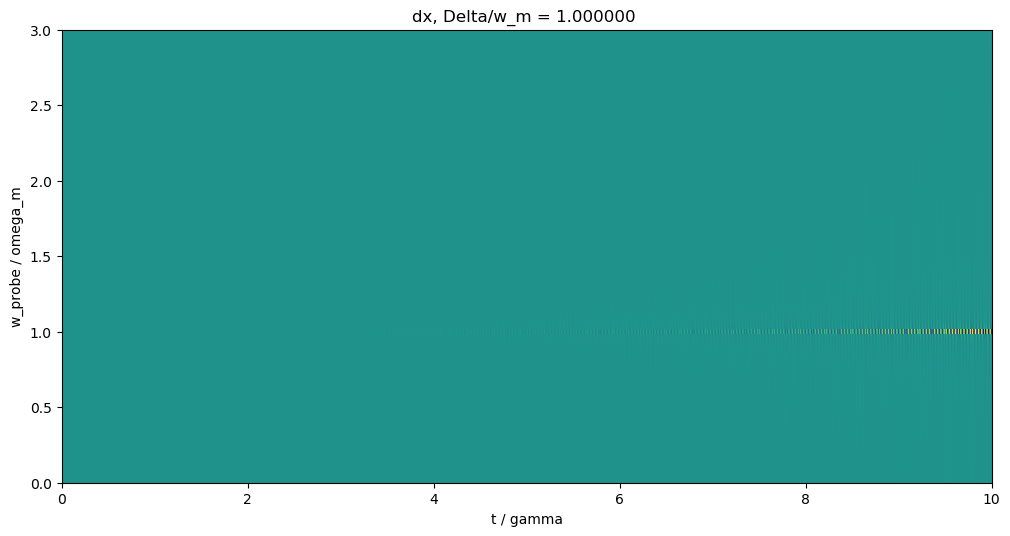

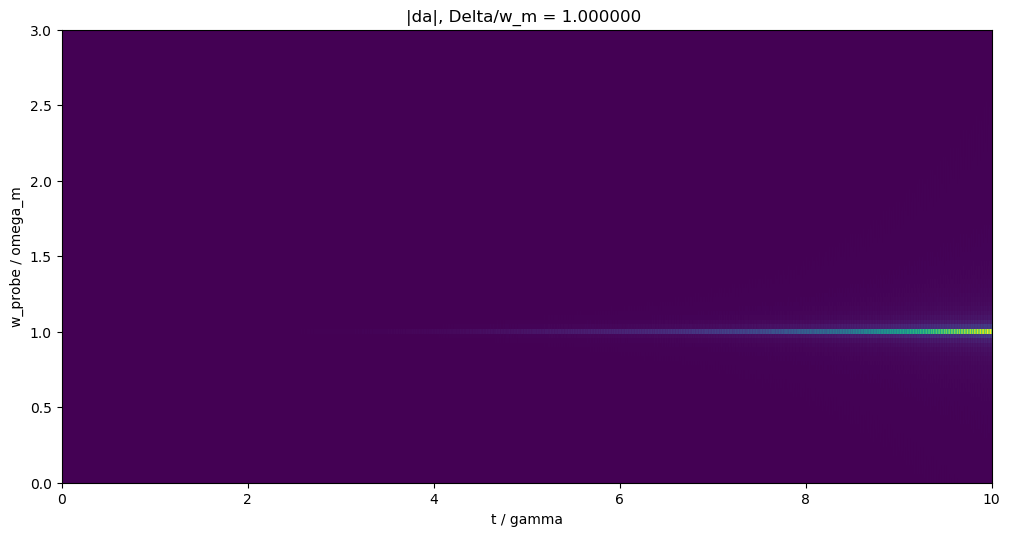

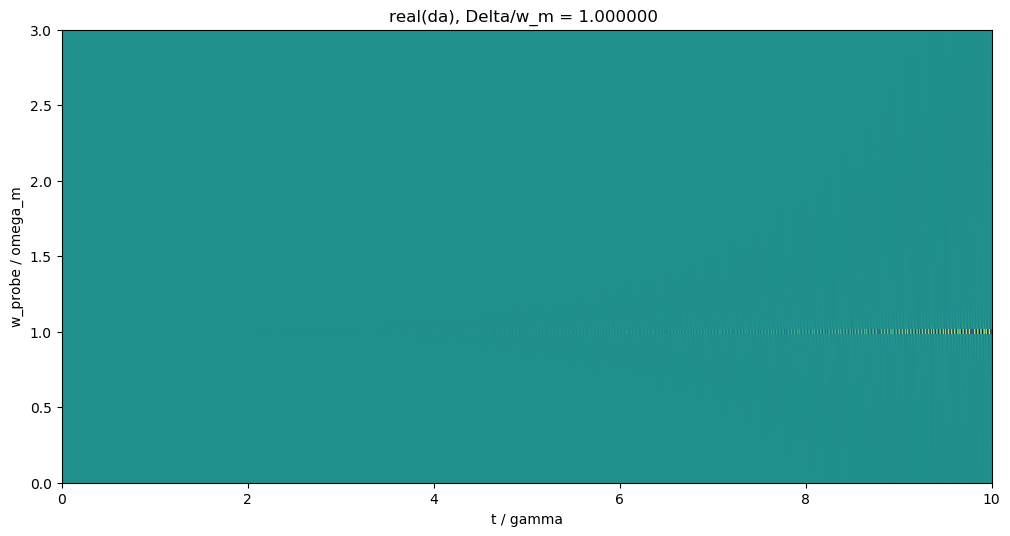

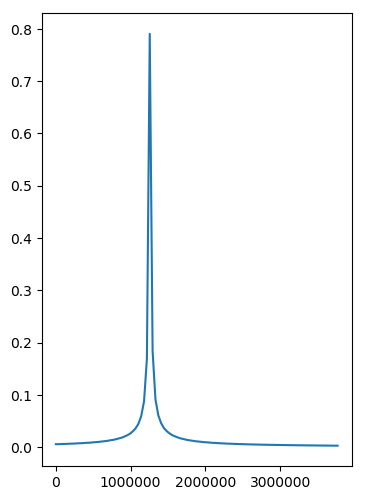

In [92]:
txt = ", Delta/w_m = %f " % (delta/w_m)

plt.figure(figsize=(12,6))
ext = (t[0]*gamma, t[-1]*gamma, w_probe[0]/w_m, w_probe[-1]/w_m)
plt.imshow(np.real(dx), origin='lower', aspect='auto', extent=ext)
plt.ylabel("w_probe / omega_m")
plt.xlabel("t / gamma")
plt.title("dx"+txt)

plt.figure(figsize=(12,6))
ext = (t[0]*gamma, t[-1]*gamma, w_probe[0]/w_m, w_probe[-1]/w_m)
plt.imshow(np.abs(da), origin='lower', aspect='auto', extent=ext)
plt.ylabel("w_probe / omega_m")
plt.xlabel("t / gamma")
plt.title("|da|"+txt)

plt.figure(figsize=(12,6))
ext = (t[0]*gamma, t[-1]*gamma, w_probe[0]/w_m, w_probe[-1]/w_m)
plt.imshow(np.real(da), origin='lower', aspect='auto', extent=ext)
plt.ylabel("w_probe / omega_m")
plt.xlabel("t / gamma")
plt.title("real(da)"+txt)

plt.figure(figsize=(4,6))
plt.plot(w_probe, np.abs(da[:,-1]))